In [1]:
%matplotlib inline

In [2]:
import os
import sys
import git
import pathlib

import random
import time


import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist


PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

from libs.constants import model_seeds, error_seeds
from libs import utils
from libs.fitnessfns import ff_mnist32_cnn_ERR, eval_mnist32_cnn_ERR
from libs.ga.ga_utils import extract_best_worst_chromosomes

import glob
import matplotlib.pyplot as plt
import ipynbname
import pandas as pd

In [3]:
# set seed
this_seed = 84376
tf.random.set_seed(this_seed)
np.random.seed(this_seed)
random.seed(this_seed)
os.environ['PYTHONHASHSEED']=str(this_seed)

In [4]:
dataset_seg_type = "all"

# error_profile_tag = "LIM_05-2188"

In [5]:

# layer = "c0"
# error_type = "ERR_-1"

In [6]:
data = {
            "FR = 1E-3":{
                            "layer":"c0", 
                            "model_type":"mnist32-cnn_1024_256_64",
                            "error_profile_tag":"LIM_01-2188",
                            "error_type":"ERR_-1"
                            },
                "FR = 2E-3":{
                            "layer":"c0", 
                            "model_type":"mnist32-cnn_1024_256_64",
                            "error_profile_tag":"LIM_02-2188",
                            "error_type":"ERR_-1"
                            },
                "FR = 5E-3":{
                            "layer":"c0", 
                            "model_type":"mnist32-cnn_1024_256_64",
                            "error_profile_tag":"LIM_05-2188",
                            "error_type":"ERR_-1"
                            },
#         "Bitflip--EP1":{
#                             "layer":"c0", 
#                             "model_type":"mnist32-cnn_1024_256_64",
#                             "error_profile_tag":"LIM_05-2188",
#                             "error_type":"ERR_-1"
#                             },
#         "Bitflip--EP2":{
#                             "layer":"c0", 
#                             "model_type":"mnist32-cnn_1024_256_64",
#                             "error_profile_tag":"LIM_05-4981",
#                             "error_type":"ERR_-1"
#                             },
    
#         "Flip-to-1--EP1":{
#                             "layer":"c0", 
#                             "model_type":"mnist32-cnn_1024_256_64",
#                             "error_profile_tag":"LIM_05-2188",
#                             "error_type":"ERR_1"
#                             },
    
#         "Flip-to-1--EP2":{
#                             "layer":"c0", 
#                             "model_type":"mnist32-cnn_1024_256_64",
#                             "error_profile_tag":"LIM_05-4981",
#                             "error_type":"ERR_1"
#                             },
    
    
    #     "fashion-c0-Bitflip":{
    #                         "layer":"c0", 
    #                         "model_type":"fashion-cnn2_1024",
    #                         "error_profile_tag":"LIM_500-2188",
    #                         "error_type":"ERR_-1"
    #                         },
    # "fashion-c1-Bitflip":{
    #                         "layer":"c1", 
    #                         "model_type":"fashion-cnn2_1024",
    #                         "error_profile_tag":"LIM_500-2188",
    #                         "error_type":"ERR_-1"
                            # },
       # "h2-BF16":{"layer":"h2", 
       #            "error_profile_tag":"LIM_500-2188",
       #              "error_type":"ERR_3"},
       # "op-BF16":{"layer":"op", 
       #            "error_profile_tag":"LIM_500-2188",
       #              "error_type":"ERR_3"},
       }

In [7]:
for layer_error in list(data.keys()):
    model_type = data[layer_error]["model_type"]
    error_profile_tag = data[layer_error]["error_profile_tag"]
    layer = data[layer_error]["layer"]
    error_type = data[layer_error]["error_type"]
    error_lim, error_seed = error_profile_tag.split('-')
    fitness_list = []

    model_instance_list = [model_type+"-"+ str(seed) for seed in [1023, 2920, 3824]]
    for model_instance in model_instance_list: 
        dataset, model_arch, model_config, layer_widths, seed = utils.instancename2metadata(model_instance)
        # model_instance = dataset-modelarch_modelconfig-seed
        model_meta_type, model_type, model_instance = utils.metadata2instancenames(dataset, 
                                                                                    model_arch, 
                                                                                    layer_widths, 
                                                                                    seed)

        # model_arch = 'cnn'
        # model_config = '1024_256_64'
        # model_type: 'mnist32-cnn_1024_256_64'
        # model_meta_type: 'mnist32-cnn'

        EXP_TYPE           = dataset_seg_type + "_"  + model_meta_type + "_" + layer + "_" + error_type
        experiment_name    = model_instance   + '--' + error_profile_tag
        ga_experiment_name = dataset_seg_type + "_"  + experiment_name + "--" + error_type + '--' + layer + '--ga_' + str(this_seed)
        # File/Folder to save log files
        logging_folder = pathlib.Path(PROJ_ROOT_PATH / "logging" / dataset_seg_type / model_type / model_instance / error_lim / error_profile_tag / error_type / layer )

        logging_filename_tag = str(pathlib.Path(logging_folder / ga_experiment_name))

        # ga outputs
        ga_output_files = glob.glob(logging_filename_tag+"*.csv")

        for filename in ga_output_files:
            df = pd.read_csv(filename)
            fitness_list.append(df['Accuracy'].tolist())




    fitness_list = np.array(fitness_list)

    fitness_list_mean = np.mean(fitness_list, axis=0)
    fitness_list_std = np.std(fitness_list, axis=0)
    fitness_list_q1 = np.percentile(fitness_list, 25, axis=0)
    fitness_list_q3 = np.percentile(fitness_list, 75, axis=0)
    
    data[layer_error]["mean"] =  fitness_list_mean
    data[layer_error]["q1"] =  fitness_list_q1
    data[layer_error]["q3"] =  fitness_list_q3

In [8]:
generations = np.arange(100)

Text(0.5, 0.98, 'mnist32--c0 layer--Bitflip error')

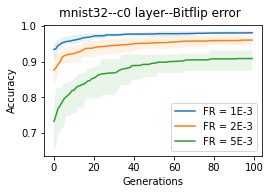

In [9]:
# Plot figure
fig_width = 3.125/0.8 
fig_height = fig_width / 1.618

fig, axs = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=[fig_width,fig_height], # in inches
                        sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.05)


for layer_error in list(data.keys()):
    fitness_list_mean = data[layer_error]["mean"]
    fitness_list_q1 = data[layer_error]["q1"]
    fitness_list_q3 = data[layer_error]["q3"]
    axs.fill_between(generations, y1=fitness_list_q1, y2=fitness_list_q3, alpha=0.1)
    axs.plot(generations, fitness_list_mean, label=layer_error)
    
    
    axs.set_xlabel("Generations")
    axs.set_ylabel("Accuracy")
    axs.legend(loc= "lower right")
    
fig.suptitle("mnist32--c0 layer--Bitflip error")

In [10]:
# Get notebook path
import ipynbname
nb_path = str(ipynbname.path())
fig_filename_tag = "ga-convergence"
fig_folder = pathlib.Path(PROJ_ROOT_PATH / "figures")
pathlib.Path(fig_folder).mkdir(parents=True, exist_ok=True)
fig_filename = pathlib.Path(fig_folder/ fig_filename_tag)
print(fig_filename)
fig.savefig(fig_filename,
    # pathlib.Path(fig_filename).with_suffix(".png"), 
            dpi=300, 
            bbox_inches='tight', 
            transparent=True, 
            metadata={"genfilepath": nb_path})

/repos/faulty_cnn/figures/ga-convergence
